In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- 1. Load the Pre-Processed Data ---
# We load the data that already has IPs merged and nulls handled
load_path = '../data/processed/fraud_data_merged.csv'
print(f"⏳ Loading merged data from {load_path}...")

try:
    df = pd.read_csv(load_path)
    print(f"✅ Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("❌ File not found. Make sure you ran the EDA/Merge step and saved the file!")

# Convert timestamps back to datetime (CSV saves them as strings)
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# --- 2. Feature Engineering ---
print("⏳ Generating features...")

# A. Temporal Features
df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.dayofweek
df['month'] = df['purchase_time'].dt.month

# B. Time Since Signup (The "Bot" Feature)
df['time_since_signup_seconds'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()

# C. Frequency Features (Velocity)
# How many times has this device or IP been seen in the dataset?
# This implies a "history" within the dataset.
df['device_freq'] = df['device_id'].map(df['device_id'].value_counts())
df['ip_freq'] = df['ip_address'].map(df['ip_address'].value_counts())

# --- 3. Encoding Categorical Features ---
print("⏳ Encoding features...")

# Frequency Encoding for Country (High Cardinality)
# If 'country' column is missing, check your merge step!
if 'country' in df.columns:
    country_freq = df['country'].value_counts(normalize=True)
    df['country_enc'] = df['country'].map(country_freq)
else:
    print("⚠️ Warning: 'country' column not found.")

# One-Hot Encoding for Low Cardinality (Source, Browser, Sex)
# We drop_first=True to reduce multicollinearity for linear models
df_encoded = pd.get_dummies(df, columns=['source', 'browser', 'sex'], drop_first=True)

# Drop columns we don't need for the model (IDs, raw timestamps, etc.)
# We KEEP 'class' as it is our target.
cols_to_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'country']
# Only drop columns that actually exist
cols_to_drop = [c for c in cols_to_drop if c in df_encoded.columns]

df_ready = df_encoded.drop(columns=cols_to_drop)

# --- 4. Normalization / Scaling ---
# Scale numerical columns for models like Logistic Regression/MLP
print("⏳ Scaling numerical features...")
scaler = StandardScaler()

# Select columns to scale (exclude 'class' and binary one-hot cols)
num_cols = ['purchase_value', 'time_since_signup_seconds', 'age', 'device_freq', 'ip_freq']
if 'country_enc' in df_ready.columns:
    num_cols.append('country_enc')

df_ready[num_cols] = scaler.fit_transform(df_ready[num_cols])
#
# # --- 5. Save Final Feature Set ---
# # This file is ready for "Task 2: Model Building"
# final_save_path = '../data/processed/fraud_data_feature_engineered.csv'
# df_ready.to_csv(final_save_path, index=False)

print(f"✅ Feature Engineering Complete.")
# print(f"File saved to: {final_save_path}")
print(f"Final Shape: {df_ready.shape}")
print("Columns ready for model:", df_ready.columns.tolist())

⏳ Loading merged data from ../data/processed/fraud_data_merged.csv...
✅ Data loaded successfully. Shape: (151112, 20)
⏳ Generating features...
⏳ Encoding features...
⏳ Scaling numerical features...
✅ Feature Engineering Complete.
Final Shape: (151112, 22)
Columns ready for model: ['purchase_value', 'age', 'class', 'time_since_signup_seconds', 'time_diff', 'device_user_count', 'ip_user_count', 'hour_of_day', 'day_of_week', 'lower_bound_ip_address', 'upper_bound_ip_address', 'month', 'device_freq', 'ip_freq', 'country_enc', 'source_Direct', 'source_SEO', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_M']


In [2]:
# --- Prepare CreditCard Data for Task 2 ---

print("⏳ Loading CreditCard data...")
try:
    credit_df = pd.read_csv('../data/raw/creditcard.csv')
    print(f"✅ CreditCard data loaded. Shape: {credit_df.shape}")
except FileNotFoundError:
    print("❌ File not found. Check path.")

# 1. Scale 'Amount' and 'Time'
# The V features are likely already centered/scaled from PCA, but Amount/Time are not.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# It's good practice to log-transform Amount because fraud often happens at small values
# but scaling is also fine. Let's stick to standard scaling for consistency.
credit_df[['Amount', 'Time']] = scaler.fit_transform(credit_df[['Amount', 'Time']])

# 2. Rename 'Class' to 'class' (lowercase)
# This makes our modeling code reusable for both datasets later!
credit_df = credit_df.rename(columns={'Class': 'class'})

# 3. Save to Processed
save_path_cc = '../data/processed/creditcard_processed.csv'
credit_df.to_csv(save_path_cc, index=False)

print(f"✅ CreditCard data processed and saved to: {save_path_cc}")
print(f"Final Columns: {credit_df.columns.tolist()}")

⏳ Loading CreditCard data...
✅ CreditCard data loaded. Shape: (284807, 31)
✅ CreditCard data processed and saved to: ../data/processed/creditcard_processed.csv
Final Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'class']


⚡ Applying Advanced Transformations...
✅ Scaler object saved to models/scaler.pkl


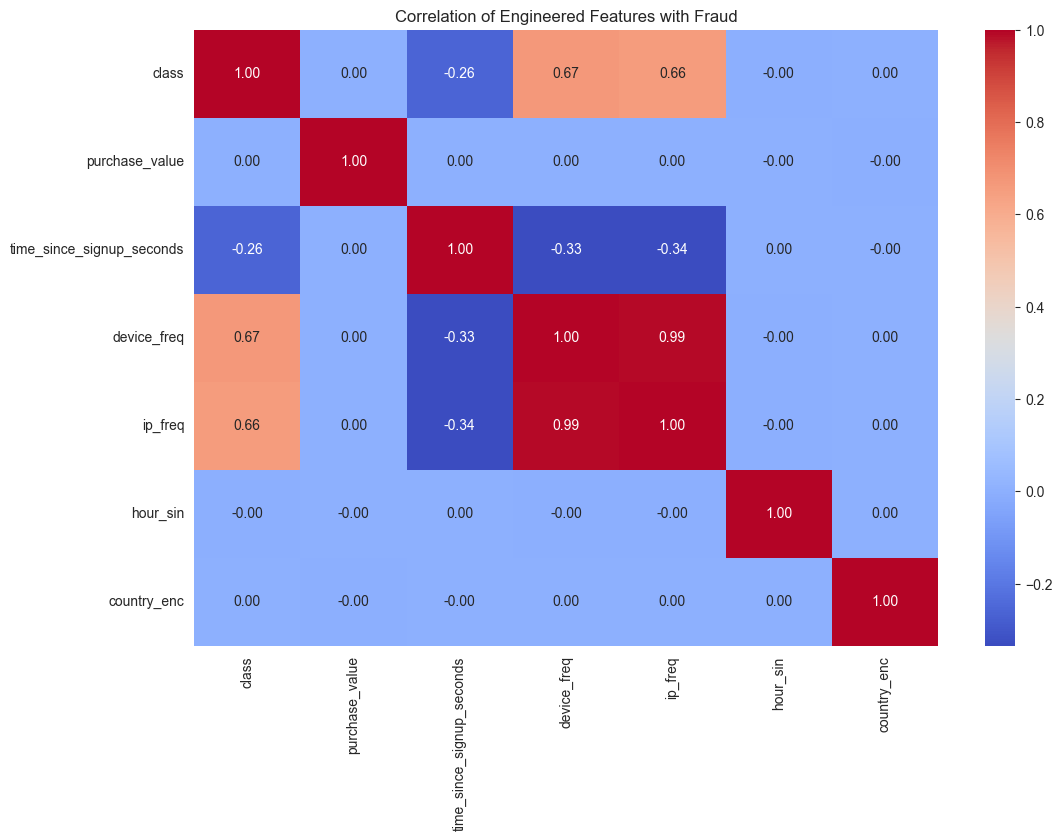

✅ Final robust dataset saved.
Final Columns: ['purchase_value', 'age', 'class', 'time_since_signup_seconds', 'time_diff', 'device_user_count', 'ip_user_count', 'hour_of_day', 'day_of_week', 'lower_bound_ip_address', 'upper_bound_ip_address', 'month', 'device_freq', 'ip_freq', 'country_enc', 'source_Direct', 'source_SEO', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_M', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [3]:
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load your processed dataframe if it's not currently in memory
# df_ready = pd.read_csv('../data/processed/fraud_data_feature_engineered.csv')

print("⚡ Applying Advanced Transformations...")

# 1. Cyclic Encoding for Time [Strengthens Report Logic]
# This helps the model understand that Hour 23 is close to Hour 0.
df_ready['hour_sin'] = np.sin(2 * np.pi * df_ready['hour_of_day'] / 24)
df_ready['hour_cos'] = np.cos(2 * np.pi * df_ready['hour_of_day'] / 24)

df_ready['month_sin'] = np.sin(2 * np.pi * df_ready['month'] / 12)
df_ready['month_cos'] = np.cos(2 * np.pi * df_ready['month'] / 12)

# We can now drop the raw linear time columns if we want, or keep them.
# For tree models, keeping both is fine. For Linear Regression, drop the raw ones.
# Let's keep them for the Random Forest but note this in the report.

# 2. Save the Scaler [Strengthens "Production Readiness"]
# We need to save the scaler we fit earlier so we can transform future data.
# Note: You need to make sure 'scaler' is the variable from your previous cell.
try:
    joblib.dump(scaler, '../models/scaler.pkl')
    print("✅ Scaler object saved to models/scaler.pkl")
except NameError:
    print("⚠️ Scaler variable not found. Make sure you ran the scaling cell!")

# 3. Final Sanity Check: Feature Correlations
# This is a great plot for your "Interim Report"
plt.figure(figsize=(12, 8))
# calculate correlation only on the new important features
corr_cols = ['class', 'purchase_value', 'time_since_signup_seconds',
             'device_freq', 'ip_freq', 'hour_sin', 'country_enc']
sns.heatmap(df_ready[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Engineered Features with Fraud")
plt.show()

# 4. Save the Final, FINAL version
df_ready.to_csv('../data/processed/fraud_data_feature_engineered.csv', index=False)
print("✅ Final robust dataset saved.")
print(f"Final Columns: {df_ready.columns.tolist()}")